In [ ]:
%load_ext autoreload
%autoreload 2
%run A_simple_net.ipynb

# scanning over single parameters

## initializing parameters

In [2]:
tag = '2020-12-04_scan'

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH
Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

numpy     : 1.19.2
matplotlib: 3.3.2
pyNN      : 0.9.5
neo       : 0.8.0
nixio     : 1.5.0b6

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-56-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

Hostname: inv-ope-de06

Git hash: f34be83854ac8bf458f81ef778714973cb6e6ef3

Git repo: https://github.com/SpikeAI/2020-11_brainhack_Project7

Git branch: main



/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.


In [3]:
buildCPUTime, simCPUTime, writeCPUTime = run(verbose=True)

/usr/lib/python3.8/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.
2020-12-04 12:16:24,497 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:24,499 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


0 Creating cell populations...
0 Initialising membrane potential to random values...
0 Connecting populations...
0 Setting up recording...0%                        
0 Running simulation...
0 Writing data to file...

--- Vogels-Abbott Network Simulation ---
Nodes                  : 1
Number of Neurons      : 400
Excitatory conductance : 4 nS
Inhibitory conductance : 51 nS
Excitatory rate        : 0.134375 Hz
Inhibitory rate        : 0.15 Hz
Build time             : 997.552 s
Simulation time        : 932.266 s
Writing time           : 146.623 s


In [4]:
%mkdir -p outputs

## Running Model and Loading Results

In [5]:
import os
import pandas as pd
verbose = True
def scan(variable, values, tag=tag, verbose=verbose):
    filename = f'outputs/{tag}_{variable}.json'
    try:
        df = pd.read_json(filename)
        print('Loaded file')
    except:
        df = pd.DataFrame([], columns=[variable, 'buildCPUTime', 'simCPUTime', 'writeCPUTime'])
        for i, value in enumerate(values):
            if verbose: print(f'{variable=}---{value=}')
            args = {}
            args[variable] = value
            buildCPUTime, simCPUTime, writeCPUTime = run(**args)
            df.loc[i]= {variable: value, 'buildCPUTime':buildCPUTime, 'simCPUTime':simCPUTime, 'writeCPUTime':writeCPUTime}
        df.to_json(filename)
    return df

In [6]:
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/31978948/python-stats-models-quadratic-term-in-regression
def plot(df):
    variable = df.columns[0]
    fig, ax = plt.subplots(figsize=(8,8))
    
    for regressor, color in zip(['buildCPUTime', 'simCPUTime', 'writeCPUTime'],
                                ['r', 'g', 'b']):

        import patsy
        y, X = patsy.dmatrices(f'{regressor} ~ {variable}', data=df, return_type='dataframe')

        import statsmodels.api as sm
        fit = sm.OLS(y, X).fit()
        print(fit.summary())

        intercept = fit.params.Intercept
        slope = fit.params[variable]

        values = np.array(df[variable])
        ax.plot(values, intercept + slope*values, c=color, lw=2, label=f"{regressor}={slope:.3f}*{variable} + {intercept:.3f}")
        df.plot(x=variable, y=regressor, c=color, lw=1, ls='-.', ax=ax, legend=False)

    ax.set_xlim(0)
    ax.set_ylabel('Time (ms)')
    ax.set_ylim(0)
    ax.legend()
    return ax

## plot as a function of neuron numbers

In [7]:
import numpy as np
N_pops = np.array([int(k)**2 for k in np.linspace(8**2, 45**2, 14, endpoint=True)**.5])
N_pops

array([  64,  196,  361,  484,  625,  784,  961, 1089, 1225, 1369, 1521,
       1681, 1849, 2025])

In [8]:
results_pop = scan('N_pop', N_pops)

2020-12-04 12:16:27,163 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:27,164 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=64


2020-12-04 12:16:27,475 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:27,477 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=196


2020-12-04 12:16:28,112 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:28,114 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=361


2020-12-04 12:16:29,234 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:29,236 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=484


2020-12-04 12:16:30,768 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:30,770 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=625


2020-12-04 12:16:32,665 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:32,667 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=784


2020-12-04 12:16:35,037 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:35,039 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=961


2020-12-04 12:16:38,021 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:38,024 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=1089


2020-12-04 12:16:41,525 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:41,528 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=1225


2020-12-04 12:16:45,476 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:45,479 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=1369


2020-12-04 12:16:49,878 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:49,881 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=1521


/home/laurent/.local/lib/python3.8/site-packages/pyNN/recording/__init__.py:264: UserWarning:Recorded at least one spike after t_stop
2020-12-04 12:16:55,055 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:16:55,058 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=1681


2020-12-04 12:17:00,798 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:00,802 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=1849


2020-12-04 12:17:07,085 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:07,089 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='N_pop'---value=2025


                            OLS Regression Results                            
Dep. Variable:           buildCPUTime   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     2279.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           4.67e-15
Time:                        12:17:14   Log-Likelihood:                -63.216
No. Observations:                  14   AIC:                             130.4
Df Residuals:                      12   BIC:                             131.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.6753     12.525     -2.609      0.0

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=14


<AxesSubplot:xlabel='N_pop', ylabel='Time (ms)'>

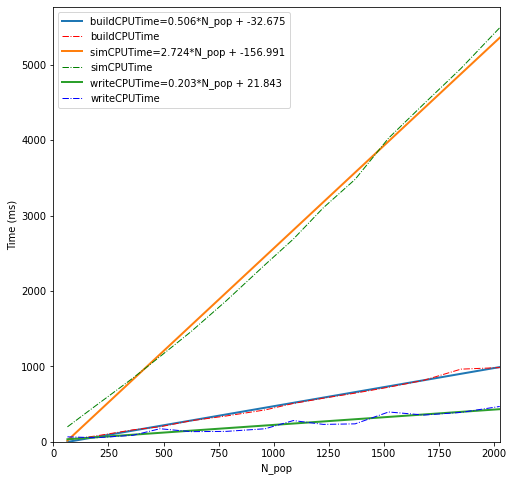

In [9]:
plot(results_pop)

## plot as a function of simtime

In [13]:
simtimes = np.linspace(500, 3000, 15, endpoint=True)
simtimes

array([ 500.        ,  678.57142857,  857.14285714, 1035.71428571,
       1214.28571429, 1392.85714286, 1571.42857143, 1750.        ,
       1928.57142857, 2107.14285714, 2285.71428571, 2464.28571429,
       2642.85714286, 2821.42857143, 3000.        ])

In [14]:
results_simtime = scan('simtime', simtimes)

variable='simtime'---value=500.0


2020-12-04 12:17:15,970 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:15,973 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:16,776 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:16,778 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=678.5714285714286


2020-12-04 12:17:17,706 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:17,708 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=857.1428571428571


2020-12-04 12:17:18,821 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:18,823 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=1035.7142857142858


2020-12-04 12:17:20,120 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:20,122 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=1214.2857142857142


2020-12-04 12:17:21,572 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:21,574 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=1392.857142857143


2020-12-04 12:17:23,207 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:23,209 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=1571.4285714285716


2020-12-04 12:17:25,027 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:25,028 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=1750.0


2020-12-04 12:17:26,992 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:26,993 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=1928.5714285714287


2020-12-04 12:17:29,145 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:29,147 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=2107.1428571428573


2020-12-04 12:17:31,452 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:31,454 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=2285.714285714286


2020-12-04 12:17:33,951 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:33,953 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=2464.2857142857147


2020-12-04 12:17:36,699 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:36,701 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=2642.857142857143


2020-12-04 12:17:39,541 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:39,543 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=2821.4285714285716


2020-12-04 12:17:42,556 WARNING  [PyNN] NEST does not allow setting an initial value for g_ex (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)
2020-12-04 12:17:42,557 WARNING  [PyNN] NEST does not allow setting an initial value for g_in (/home/laurent/.local/lib/python3.8/site-packages/pyNN/nest/populations.py[174]:_set_initial_value_array)


variable='simtime'---value=3000.0


                            OLS Regression Results                            
Dep. Variable:           buildCPUTime   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.931
Date:                Fri, 04 Dec 2020   Prob (F-statistic):              0.188
Time:                        12:17:45   Log-Likelihood:                -67.357
No. Observations:                  15   AIC:                             138.7
Df Residuals:                      13   BIC:                             140.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    205.6551     14.834     13.864      0.0

/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15
/usr/lib/python3/dist-packages/scipy/stats/stats.py:1449: UserWarning:kurtosistest only valid for n>=20 ... continuing anyway, n=15


<AxesSubplot:xlabel='simtime', ylabel='Time (ms)'>

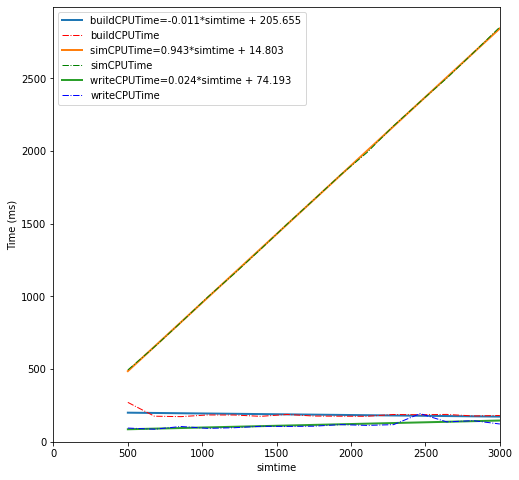

In [15]:
plot(results_simtime)      

# scanning over two parameters

## Setting-up model and initializing parameters

In [18]:
tag = '2020-12-04_scan-2D'

## Running Model and Loading Results

In [ ]:
variables = ['N_pop', 'simtime']
filename = f'outputs/{args.tag}'
for variable in variables: filename +=  '_' + variable
filename += '.json'

In [ ]:
import os
import time
import pandas as pd
verbose = True
def scan(variables, values, tag=args.tag, verbose=verbose):
    filename = f'outputs/{args.tag}'
    for variable in variables: filename +=  '_' + variable
    filename += '.json'
    try:
        df = pd.read_json(filename)
        print('Loaded file')
    except:
        
        df = pd.DataFrame([], columns=[variable, 'buildCPUTime', 'simCPUTime', 'writeCPUTime'])
        for i, value in enumerate(values):
            if verbose: print(f'{variable=}---{value=}')
            args = {}
            for variable, v in zip(variables, value):
                args[variable] = v
            buildCPUTime, simCPUTime, writeCPUTime = run(**args)
            df.loc[i]= dict(zip(variables + ['buildCPUTime', 'simCPUTime', 'writeCPUTime'], 
                                list(value) + [buildCPUTime, simCPUTime, writeCPUTime]))

        df.to_json(filename)
        
    return df

## Running time as a function of neuron numbers and simtime

In [ ]:
import numpy as np

In [ ]:
N_trials = 200
N_pops = [int(k)**2 for k in np.linspace(15, 60, N_trials, endpoint=True)]
simtimes = np.linspace(200, 3000, N_trials, endpoint=True)

In [ ]:
np.random.seed(42)
np.random.shuffle(N_pops)
np.random.shuffle(simtimes)
values = zip(N_pops, simtimes)

In [ ]:
results = scan(variables=variables, values=values)
results

## analysis

In [ ]:
results_ext = results.copy()
results_ext['simtime_N_pop'] = results_ext['simtime'] * results_ext['N_pop']
results_ext

In [ ]:
variables_ext = ['N_pop', 'simtime_N_pop']
X = results_ext[variables_ext].values.reshape(-1, len(variables_ext))
y = results_ext['runtime'].values
print(variables_ext, X.shape, y.shape)

https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python

See https://patsy.readthedocs.io/en/latest/quickstart.html

In [ ]:
import patsy
import statsmodels.api as sm

y, X = patsy.dmatrices('runtime ~ 0 + N_pop + simtime_N_pop', data=results_ext, return_type='dataframe')

fit = sm.OLS(y, X).fit()
fit.summary()

In [ ]:
print(f'running_time (ms) = {fit.params[0]:.3f} * N_pop + {fit.params[1]*1000:.3f}/1000 * simtime (ms) * N_pop')